# Wavelet Shrinkage Experiment: Doppler Signal, SNR = 7

This notebook demonstrates wavelet–domain denoising of the Donoho–Johnstone Doppler test signal ($N = 1024$) using multiple shrinkage rules:
- Hard thresholding
- Soft thresholding
- SCAD (Fan & Li)
- Smooth SCAD (raised–cosine formulation)

Noise is added so that the variance ratio satisfies
$$
\mathrm{SNR} = \frac{\mathrm{Var}(\text{signal})}{\mathrm{Var}(\text{noise})} = 7,
$$
with Gaussian noise $\varepsilon \sim N(0, \sigma^2)$.

The universal wavelet threshold is defined as
$$
\lambda_U = \sigma \sqrt{2 \log N}.
$$

Oracle–selected thresholds $\lambda^\*$ are computed by minimizing the empirical mean–squared error relative to the clean Doppler signal:
$$
\lambda^\* = \arg\min_{\lambda} \frac{1}{N} \sum_{i=1}^N \left( \hat{x}_\lambda(i) - x_{\mathrm{clean}}(i) \right)^2.
$$

The notebook will display:
1. The clean Doppler function vs. its noisy version
2. Universal–threshold reconstructions
3. Best (oracle) SCAD and Smooth–SCAD reconstructions


True sigma      = 0.1092
Effective SNR   = 7.000 (variance ratio)
Using wavelet sym4, max level J = 7
Universal threshold lambda_U = 0.4065

Mean squared errors (MSE) relative to clean Doppler:
  Noisy signal (baseline)       : 0.012330
  Universal HARD threshold      : 0.001916
  Universal SOFT threshold      : 0.005809
  Best SCAD     (a = 2.0) : 0.001687 (lambda = 0.2064)
  Best smooth SCAD (a = 2.0): 0.001751 (lambda = 0.2585)


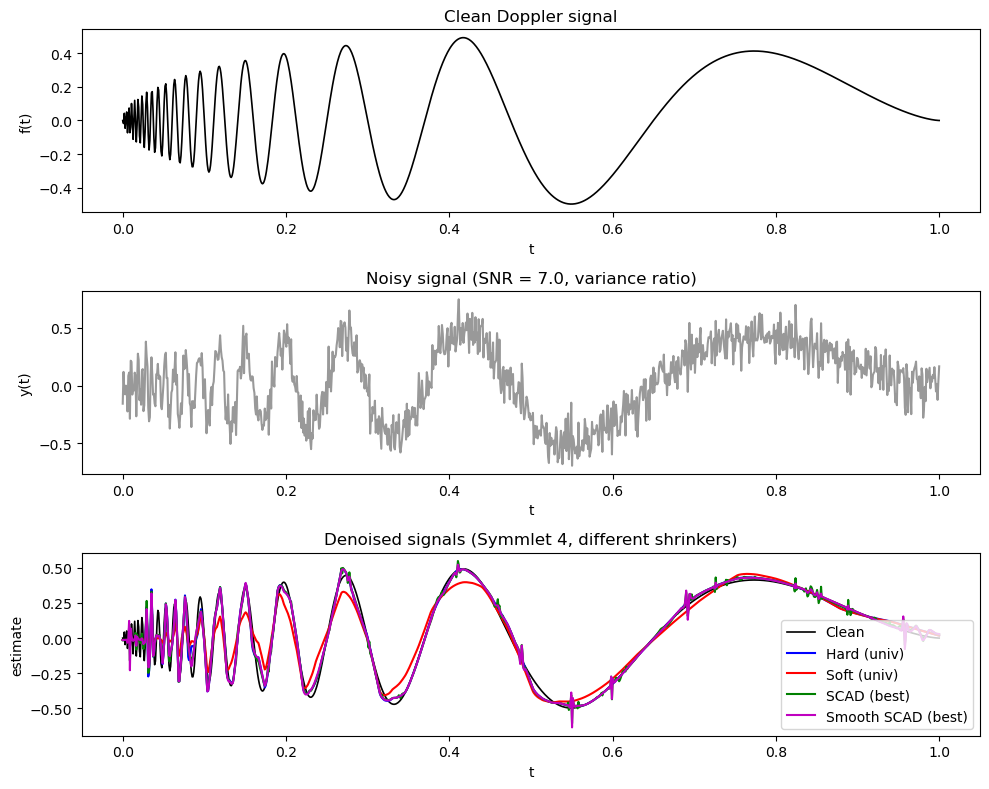

In [2]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1. Generate Doppler signal and noisy observation
# --------------------------------------------------------------

def doppler_signal(N):
    """Donoho–Johnstone Doppler test function of length N."""
    t = np.linspace(0.0, 1.0, N)
    return t, np.sqrt(t * (1.0 - t)) * np.sin((2.0 * np.pi * 1.05) / (t + 0.05))


def add_noise_snr_var(x, snr_var, rng=None):
    """
    Add Gaussian noise so that SNR = Var(signal) / Var(noise) = snr_var.
    Returns noisy signal, sigma, and actual SNR.
    """
    if rng is None:
        rng = np.random.default_rng()
    signal_var = np.var(x)
    noise_var = signal_var / snr_var
    sigma = np.sqrt(noise_var)
    noise = sigma * rng.standard_normal(size=x.shape)
    y = x + noise
    return y, sigma, signal_var / noise_var


# --------------------------------------------------------------
# 2. Wavelet denoising utilities
# --------------------------------------------------------------

def shrink_hard(d, lam):
    """Hard thresholding."""
    d = np.asarray(d)
    return d * (np.abs(d) > lam)


def shrink_soft(d, lam):
    """Soft thresholding."""
    d = np.asarray(d)
    return np.sign(d) * np.maximum(np.abs(d) - lam, 0.0)


def shrink_scad(d, lam, a=3.7):
    """
    Standard SCAD thresholding (Fan & Li) with parameter a > 2.
    Piecewise definition on |d|.
    """
    d = np.asarray(d)
    x = np.abs(d)
    s = np.sign(d)

    out = np.zeros_like(d)

    # Region 1: |d| <= lam -> 0 (already)
    # Region 2: lam < |d| <= 2*lam
    mask2 = (x > lam) & (x <= 2.0 * lam)
    out[mask2] = s[mask2] * (x[mask2] - lam)

    # Region 3: 2*lam < |d| <= a*lam
    mask3 = (x > 2.0 * lam) & (x <= a * lam)
    out[mask3] = s[mask3] * ((a - 1.0) * x[mask3] - a * lam) / (a - 2.0)

    # Region 4: |d| > a*lam -> unshrunk
    mask4 = x > a * lam
    out[mask4] = d[mask4]

    return out


def shrink_smooth_scad(d, lam, a=3.7):
    """
    Smooth SCAD shrinkage via raised cosine transition.

    Generator h(|d|,lam):
      h = lam * cos^2( pi/2 * (|d|-lam)/((a-1)*lam) ),  lam < |d| < a*lam
      h = lam,         |d| in (0, lam]
      h = 0,           |d| >= a*lam, or |d| = 0

    Thresholding rule:
      rho(d) = 0                      if |d| <= lam
             = d - sign(d)*h(|d|,lam) if lam < |d| < a*lam
             = d                      if |d| >= a*lam
    """
    d = np.asarray(d)
    x = np.abs(d)
    s = np.sign(d)

    out = np.zeros_like(d)

    # Region 1: |d| <= lam -> 0 (already)

    # Region 2: lam < |d| < a*lam
    mask2 = (x > lam) & (x < a * lam)
    x2 = x[mask2]
    # normalized transition parameter
    trans = (x2 - lam) / ((a - 1.0) * lam)
    h_val = lam * np.cos(0.5 * np.pi * trans) ** 2
    out[mask2] = d[mask2] - s[mask2] * h_val

    # Region 3: |d| >= a*lam -> unshrunk
    mask3 = x >= a * lam
    out[mask3] = d[mask3]

    return out


def denoise_wavelet(y, wavelet, level, lam, shrink_type="hard", a=3.7):
    """
    Orthogonal DWT denoising with various shrinkage rules.

    Parameters
    ----------
    y : array_like
        Noisy signal.
    wavelet : str or pywt.Wavelet
        Wavelet name (e.g. 'sym4') or Wavelet object.
    level : int
        Decomposition level.
    lam : float
        Threshold parameter.
    shrink_type : {'hard','soft','scad','ssc'}
        Shrinkage rule.
    a : float
        Shape parameter for SCAD / smooth SCAD.
    """
    coeffs = pywt.wavedec(y, wavelet, level=level)
    cA = coeffs[0]
    details = coeffs[1:]

    denoised_details = []
    for d in details:
        if shrink_type == "hard":
            d_thr = shrink_hard(d, lam)
        elif shrink_type == "soft":
            d_thr = shrink_soft(d, lam)
        elif shrink_type.lower() == "scad":
            d_thr = shrink_scad(d, lam, a=a)
        elif shrink_type.lower() in ("ssc", "smooth_scad"):
            d_thr = shrink_smooth_scad(d, lam, a=a)
        else:
            raise ValueError(f"Unknown shrink_type: {shrink_type}")
        denoised_details.append(d_thr)

    coeffs_denoised = [cA] + denoised_details
    y_hat = pywt.waverec(coeffs_denoised, wavelet)

    # In case of rounding / padding, truncate to original length
    return y_hat[: len(y)]


# --------------------------------------------------------------
# 3. Main experiment
# --------------------------------------------------------------

if __name__ == "__main__":
    rng = np.random.default_rng(12345)

    N = 1024
    snr_var = 7.0

    # 3.1 Doppler + noise
    t, f_true = doppler_signal(N)
    y, sigma, snr_eff = add_noise_snr_var(f_true, snr_var, rng=rng)

    print(f"True sigma      = {sigma:.4f}")
    print(f"Effective SNR   = {snr_eff:.3f} (variance ratio)")

    # 3.2 Wavelet and universal threshold
    wname = "sym4"
    wavelet = pywt.Wavelet(wname)
    max_level = pywt.dwt_max_level(N, wavelet.dec_len)

    # To mirror the MATLAB behavior you can just use max_level;
    # or fix a smaller level if you wish. Here we use max_level.
    J = max_level
    print(f"Using wavelet {wname}, max level J = {J}")

    lambda_U = sigma * np.sqrt(2.0 * np.log(N))
    print(f"Universal threshold lambda_U = {lambda_U:.4f}")

    # 3.3 Denoising with various rules
    # Baseline MSE (no denoising)
    mse_noisy = np.mean((y - f_true) ** 2)

    # (a) Universal hard
    y_hard = denoise_wavelet(y, wavelet, J, lambda_U, shrink_type="hard")
    mse_hard = np.mean((y_hard - f_true) ** 2)

    # (b) Universal soft
    y_soft = denoise_wavelet(y, wavelet, J, lambda_U, shrink_type="soft")
    mse_soft = np.mean((y_soft - f_true) ** 2)

    # (c) Oracle SCAD (search over lambda grid)
    a_scad = 2
    lambda_grid_scad = np.linspace(0.2 * lambda_U, 1.2 * lambda_U, 40)

    best_mse_scad = np.inf
    best_lambda_scad = None
    best_y_scad = None

    for lam in lambda_grid_scad:
        y_tmp = denoise_wavelet(y, wavelet, J, lam, shrink_type="scad", a=a_scad)
        mse_tmp = np.mean((y_tmp - f_true) ** 2)
        if mse_tmp < best_mse_scad:
            best_mse_scad = mse_tmp
            best_lambda_scad = lam
            best_y_scad = y_tmp

    # (d) Oracle smooth SCAD (raised cosine, same grid)
    a_ssc = 2
    lambda_grid_ssc = np.linspace(0.2 * lambda_U, 1.2 * lambda_U, 40)

    best_mse_ssc = np.inf
    best_lambda_ssc = None
    best_y_ssc = None

    for lam in lambda_grid_ssc:
        y_tmp = denoise_wavelet(y, wavelet, J, lam, shrink_type="ssc", a=a_ssc)
        mse_tmp = np.mean((y_tmp - f_true) ** 2)
        if mse_tmp < best_mse_ssc:
            best_mse_ssc = mse_tmp
            best_lambda_ssc = lam
            best_y_ssc = y_tmp

    # ----------------------------------------------------------
    # 4. Report MSEs
    # ----------------------------------------------------------
    print("\nMean squared errors (MSE) relative to clean Doppler:")
    print(f"  Noisy signal (baseline)       : {mse_noisy:.6f}")
    print(f"  Universal HARD threshold      : {mse_hard:.6f}")
    print(f"  Universal SOFT threshold      : {mse_soft:.6f}")
    print(
        f"  Best SCAD     (a = {a_scad:.1f}) : {best_mse_scad:.6f} "
        f"(lambda = {best_lambda_scad:.4f})"
    )
    print(
        f"  Best smooth SCAD (a = {a_ssc:.1f}): {best_mse_ssc:.6f} "
        f"(lambda = {best_lambda_ssc:.4f})"
    )

    # ----------------------------------------------------------
    # 5. Plots
    # ----------------------------------------------------------
    plt.figure(figsize=(10, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, f_true, "k", linewidth=1.2)
    plt.title("Clean Doppler signal")
    plt.xlabel("t")
    plt.ylabel("f(t)")

    plt.subplot(3, 1, 2)
    plt.plot(t, y, color="0.6")
    plt.title(f"Noisy signal (SNR = {snr_var:.1f}, variance ratio)")
    plt.xlabel("t")
    plt.ylabel("y(t)")

    plt.subplot(3, 1, 3)
    plt.plot(t, f_true, "k", linewidth=1.2, label="Clean")
    plt.plot(t, y_hard, "b", label="Hard (univ)")
    plt.plot(t, y_soft, "r", label="Soft (univ)")
    plt.plot(t, best_y_scad, "g", label="SCAD (best)")
    plt.plot(t, best_y_ssc, "m", label="Smooth SCAD (best)")
    plt.xlabel("t")
    plt.ylabel("estimate")
    plt.title("Denoised signals (Symmlet 4, different shrinkers)")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


# AMSE Study for Wavelet Shrinkage on the Doppler Signal

This notebook computes and compares **average mean–squared error (AMSE)** over repeated noise realizations for several denoising rules applied to the Donoho–Johnstone Doppler test function. The Doppler signal is
$$
f(t) = \sqrt{t(1-t)} \,\sin\!\left(\frac{2\pi \cdot 1.05}{t + 0.05}\right), \qquad t \in [0,1],
$$
sampled at $N = 1024$ equally spaced points.

Noise is injected so that the variance ratio
$$
\mathrm{SNR} = \frac{\mathrm{Var}(\text{signal})}{\mathrm{Var}(\text{noise})}
$$
equals $7$, by drawing $\varepsilon \sim N(0,\sigma^2)$ and setting $y = f + \varepsilon$.

Wavelet shrinkage is performed using the Symmlet–4 orthogonal wavelet and a decomposition level
$$
J = \mathrm{dwt\_max\_level}(N).
$$

Shrinkage rules evaluated:

- Hard thresholding
- Soft thresholding
- SCAD (Fan–Li–type)
- Smooth SCAD (raised–cosine transition)

The universal threshold is
$$
\lambda_U = \sigma \sqrt{2 \log N},
$$
while SCAD and Smooth–SCAD obtain **oracle thresholds** each replication by minimizing the empirical MSE relative to $f(t)$.

The AMSE values are computed as:
$$
\mathrm{AMSE} = \frac{1}{M} \sum_{m=1}^{M} 
\frac{1}{N} \sum_{i=1}^{N} 
\left( \hat{f}^{(m)}(t_i) - f(t_i) \right)^2,
$$
with $M = 500$ Monte Carlo runs.

This notebook outputs:
1. Estimated AMSE for each shrinker
2. Comparative performance of universal vs. oracle thresholds


In [2]:
import numpy as np
import pywt

# ===============================================
# 1. Doppler + Noise model
# ===============================================

def doppler_signal(N):
    """Donoho–Johnstone Doppler test function."""
    t = np.linspace(0.0, 1.0, N)
    return np.sqrt(t * (1.0 - t)) * np.sin((2.0 * np.pi * 1.05) / (t + 0.05))


def add_noise_snr_var(x, snr, rng):
    """Add Gaussian noise so that SNR = Var(x)/Var(noise)."""
    signal_var = np.var(x)
    noise_var = signal_var / snr
    sigma = np.sqrt(noise_var)
    noise = sigma * rng.standard_normal(size=x.shape)
    y = x + noise
    return y, sigma


# ===============================================
# 2. Shrinkage rules
# ===============================================

def shrink_hard(d, lam):
    return d * (np.abs(d) > lam)

def shrink_soft(d, lam):
    return np.sign(d) * np.maximum(np.abs(d) - lam, 0.0)

def shrink_scad(d, lam, a=3.7):
    d = np.asarray(d)
    x = np.abs(d)
    s = np.sign(d)
    out = np.zeros_like(d)

    mask2 = (x > lam) & (x <= 2*lam)
    out[mask2] = s[mask2] * (x[mask2] - lam)

    mask3 = (x > 2*lam) & (x <= a*lam)
    out[mask3] = s[mask3] * ((a-1.0)*x[mask3] - a*lam) / (a-2.0)

    mask4 = (x > a*lam)
    out[mask4] = d[mask4]

    return out

def shrink_smooth_scad(d, lam, a=3.7):
    d = np.asarray(d)
    x = np.abs(d)
    s = np.sign(d)
    out = np.zeros_like(d)

    mask2 = (x > lam) & (x < a*lam)
    x2 = x[mask2]
    trans = (x2 - lam) / ((a - 1.0) * lam)
    h_val = lam * np.cos(0.5*np.pi*trans)**2
    out[mask2] = d[mask2] - s[mask2] * h_val

    mask3 = (x >= a*lam)
    out[mask3] = d[mask3]

    return out


def denoise_wavelet(y, wavelet, level, lam, shrink_type, a=3.7):
    coeffs = pywt.wavedec(y, wavelet, level=level)
    cA, details = coeffs[0], coeffs[1:]
    new_details = []
    for d in details:
        if shrink_type == "hard":
            d_thr = shrink_hard(d, lam)
        elif shrink_type == "soft":
            d_thr = shrink_soft(d, lam)
        elif shrink_type == "scad":
            d_thr = shrink_scad(d, lam, a=a)
        elif shrink_type == "ssc":
            d_thr = shrink_smooth_scad(d, lam, a=a)
        else:
            raise ValueError
        new_details.append(d_thr)
    return pywt.waverec([cA]+new_details, wavelet)[:len(y)]


# ===============================================
# 3. AMSE Experiment
# ===============================================

def compute_AMSE(M=500, N=1024, snr=7):
    rng = np.random.default_rng(2025)
    f_true = doppler_signal(N)

    wname = "sym4"
    wavelet = pywt.Wavelet(wname)
    J = pywt.dwt_max_level(N, wavelet.dec_len)

    mse_h = []; mse_s = []; mse_scad = []; mse_ssc = []

    for m in range(M):
        y, sigma = add_noise_snr_var(f_true, snr, rng)
        lamU = sigma * np.sqrt(2.0 * np.log(N))

        # Universal hard
        est_h = denoise_wavelet(y, wavelet, J, lamU, "hard")
        mse_h.append(np.mean((est_h - f_true)**2))

        # Universal soft
        est_s = denoise_wavelet(y, wavelet, J, lamU, "soft")
        mse_s.append(np.mean((est_s - f_true)**2))

        # SCAD – lambda chosen each run only by minimizing true MSE (oracle)
        a_scad = 3.7
        lam_grid = np.linspace(0.2*lamU, 1.2*lamU, 40)
        best = 1e9
        for lam in lam_grid:
            est = denoise_wavelet(y, wavelet, J, lam, "scad", a=a_scad)
            mse_tmp = np.mean((est - f_true)**2)
            if mse_tmp < best:
                best = mse_tmp
        mse_scad.append(best)

        # Smooth SCAD oracle
        a_ssc = 3.7
        best2 = 1e9
        for lam in lam_grid:
            est = denoise_wavelet(y, wavelet, J, lam, "ssc", a=a_ssc)
            mse_tmp = np.mean((est - f_true)**2)
            if mse_tmp < best2:
                best2 = mse_tmp
        mse_ssc.append(best2)

    return {
        "AMSE hard" : np.mean(mse_h),
        "AMSE soft" : np.mean(mse_s),
        "AMSE SCAD": np.mean(mse_scad),
        "AMSE smooth SCAD": np.mean(mse_ssc)
    }


# ===============================================
# 4. Run
# ===============================================

if __name__ == "__main__":
    out = compute_AMSE(M=500, N=1024, snr=7)
    print("\n=====================")
    print("AMSE RESULTS (M=500)")
    print("=====================")
    for k,v in out.items():
        print(f"{k:20s} : {v:.6f}")



AMSE RESULTS (M=500)
AMSE hard            : 0.002031
AMSE soft            : 0.005338
AMSE SCAD            : 0.001742
AMSE smooth SCAD     : 0.001697


In [1]:
import numpy as np
import pywt
from sklearn.metrics import mean_squared_error

# ============================================
# Smooth SCAD helper shrinkage
# ============================================
def smooth_scad_threshold(coeffs, lam, a=3.0):
    out = np.zeros_like(coeffs)
    for i, d in enumerate(coeffs):
        absd = abs(d)
        if absd <= lam:
            out[i] = 0.0
        elif absd >= a*lam:
            out[i] = d
        else:
            s = (absd-lam)/((a-1)*lam)
            h = lam*(np.cos((np.pi/2.)*s)**2)
            out[i] = np.sign(d)*(absd - h)
    return out

# ============================================
# SCAD shrinkage (Fan-Li) oracle-tuned
# ============================================
def scad_threshold(coeffs, lam, a=3.7):
    out = np.zeros_like(coeffs)
    for i, d in enumerate(coeffs):
        ad = abs(d)
        if ad <= lam:
            out[i] = 0.0
        elif ad <= 2*lam:
            out[i] = np.sign(d)*(ad - lam)
        elif ad <= a*lam:
            out[i] = np.sign(d)*(((a-1)*ad - a*lam)/(a-2))
        else:
            out[i] = d
    return out

# ============================================
# DOPPLER test function (Donoho–Johnstone)
# ============================================
def doppler(N):
    x = np.linspace(0,1,N)
    return np.sqrt(x*(1-x)) * np.sin((2*np.pi*1.05)/(x+0.05))

# ============================================
# Universal threshold
# ============================================
def univ_thresh(sigma, N):
    return sigma * np.sqrt(2*np.log(N))

# ============================================
# Monte Carlo experiment
# ============================================
def run_monte_carlo(M=1000, N=1024, sigma=1.0, SNR=7.0):
    base = doppler(N)
    # scale so that signal variance = SNR
    var = np.var(base)
    scale = np.sqrt(SNR / var)
    f = base * scale   # scaled signal
    wavelet = 'sym4'

    MSE_hard, MSE_soft, MSE_scad, MSE_sscad = [], [], [], []

    for _ in range(M):
        noise = sigma*np.random.randn(N)
        y = f + noise

        # Wavelet decomposition
        coeffs = pywt.wavedec(y, wavelet, mode='per', level=None)
        dcoeffs = coeffs[1:]                        # details only
        cA = coeffs[0]                              # approximation

        lam_u = univ_thresh(sigma, N)

        # HARD
        d_hard = [pywt.threshold(c, lam_u, mode='hard') for c in dcoeffs]
        rec_hard = pywt.waverec([cA]+d_hard, wavelet, mode='per')
        MSE_hard.append(mean_squared_error(f, rec_hard))

        # SOFT
        d_soft = [pywt.threshold(c, lam_u, mode='soft') for c in dcoeffs]
        rec_soft = pywt.waverec([cA]+d_soft, wavelet, mode='per')
        MSE_soft.append(mean_squared_error(f, rec_soft))

        # SCAD – oracle: search λ on grid
        lam_grid = np.linspace(0.2, lam_u, 25)
        best = 1e9
        for lam in lam_grid:
            d_list = [scad_threshold(c, lam) for c in dcoeffs]
            rec = pywt.waverec([cA]+d_list, wavelet, mode='per')
            mse = mean_squared_error(f, rec)
            if mse < best:
                best = mse
        MSE_scad.append(best)

        # Smooth SCAD – same grid
        best_s = 1e9
        for lam in lam_grid:
            d_list = [smooth_scad_threshold(c, lam, a=3.0) for c in dcoeffs]
            rec = pywt.waverec([cA]+d_list, wavelet, mode='per')
            mse = mean_squared_error(f, rec)
            if mse < best_s:
                best_s = mse
        MSE_sscad.append(best_s)

    # statistics
    AMSE_h, AMSE_s, AMSE_c, AMSE_ss = map(np.mean, [MSE_hard, MSE_soft, MSE_scad, MSE_sscad])
    STD_h, STD_s, STD_c, STD_ss = map(np.std, [MSE_hard, MSE_soft, MSE_scad, MSE_sscad])

    return (AMSE_h, AMSE_s, AMSE_c, AMSE_ss), (STD_h, STD_s, STD_c, STD_ss)


if __name__ == "__main__":
    AMSE, STD = run_monte_carlo()
    print("Results for Doppler N=1024, SNR=7, sigma=1, M=1000:")
    print("AMSE:")
    print(f"Hard: {AMSE[0]:.6f}, Soft: {AMSE[1]:.6f}, SCAD: {AMSE[2]:.6f}, SmoothSCAD: {AMSE[3]:.6f}")
    print("Std(MSE):")
    print(f"({STD[0]:.6f}), ({STD[1]:.6f}), ({STD[2]:.6f}), ({STD[3]:.6f})")


Results for Doppler N=1024, SNR=7, sigma=1, M=1000:
AMSE:
Hard: 0.154805, Soft: 0.403138, SCAD: 0.134149, SmoothSCAD: 0.131094
Std(MSE):
(0.017769), (0.032662), (0.014178), (0.014159)
